#**Cognition & Computation Project**


---


**Berke Furkan Kusmenoglu** 

**2041496**

**berkefurkan.kusmenoglu@studenti.unipd.it**

#**Visual Concept Learning for Hand Written Letter Recognition**


#**Introduction**
As we know, supervised learning has been proven to be beneficial in the field of machine learning, but the need for large amounts of labeled data can be a limitation. As a result, unsupervised learning is becoming more favorable. The project being described involves introducing models to improve handwriting recognition using the EMNIST dataset. These models include a Deep Belief Network with multiple layers and linear readouts, as well as Feed Forward Neural Networks and Perceptron models. Additionally, the text notes that the robustness of these models against noise will be explored, including both Gaussian noise and adversarial attacks.

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import torch
import torchvision as tv
import torch.nn.functional as functional
import tqdm


from DBN import DBN

lbl=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

#**Preprocess the EMNIST Dataset**

EMNIST dataset is an extension of the original MNIST dataset, which contains images of handwritten digits. The EMNIST dataset includes additional characters, such as uppercase and lowercase letters, as well as special characters. This increases the number of classes from 10 in the original MNIST dataset to 62 in the EMNIST dataset which include 10 digits (0-9), 26 uppercase letters (A-Z), 26 lowercase letters (a-z), and an additional special character class.

EMNIST is a dataset of handwritten characters and digits that is often used as a benchmark dataset for machine learning and computer vision tasks. It is particularly useful for training and testing models for handwriting recognition. The dataset contains over 600,000 images of handwritten characters and digits, with a balanced distribution of samples for each class. The images are 28x28 pixels in size and are grayscale, with each pixel represented by a single 8-bit value.

It is a widely used dataset in the research community, and it is often used as a benchmark for evaluating the performance of machine learning models on handwriting recognition tasks.

In [4]:
transform = tv.transforms.Compose([tv.transforms.ToTensor()])

emnist_train = tv.datasets.EMNIST(root='data/', train=True, download=True, split='letters', transform=transform)

emnist_test = tv.datasets.EMNIST(root='data/', train=False, download=True, split='letters', transform=transform)


  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw



Grayscale refers to the conversion of an image from a color representation to a 
monochrome representation. In a grayscale image, each pixel is represented by a single intensity value, typically in the range of 0-255, where 0 represents black, 255 represents white, and values in between represent shades of gray.

Grayscale images are typically stored using 8 bits per pixel, which allows for up to 256 different intensity values. This is in contrast to color images, which are typically stored using 24 bits per pixel (8 bits each for red, green, and blue channels).

Grayscale images are simpler to process than color images and are often used in image processing and computer vision applications. They also require less storage space and can be transmitted more efficiently.

To decrease computational cost, the samples are converted to grayscale and the labels are transformed into one-hot encoding based on the letter's position in the alphabet, for example, 'a' is labeled as 0 and 'z' is labeled as 25.

In [5]:
#greyscaling 
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

The project utilizes 145,600 handwritten letters from the EMNIST dataset. These letters are transformed into 28x28 pixel images and are divided into 26 classes, each with 5600 samples. The samples may not have the same orientation and can be rotated or flipped horizontally and vertically. The dataset is split into a training set with 124,800 samples and a test set with 20,800 samples.

In [6]:
emnist_train

Dataset EMNIST
    Number of datapoints: 124800
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [7]:
emnist_test

Dataset EMNIST
    Number of datapoints: 20800
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Actual number: 7


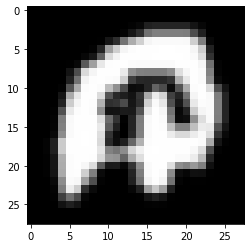

In [8]:
idx = 1
img = emnist_train.data[idx]
print("Actual number: {}".format(emnist_train.targets[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

In [9]:
train_data = emnist_train.data
train_targets = emnist_train.targets - 1
test_data = emnist_test.data
test_targets = emnist_test.targets - 1


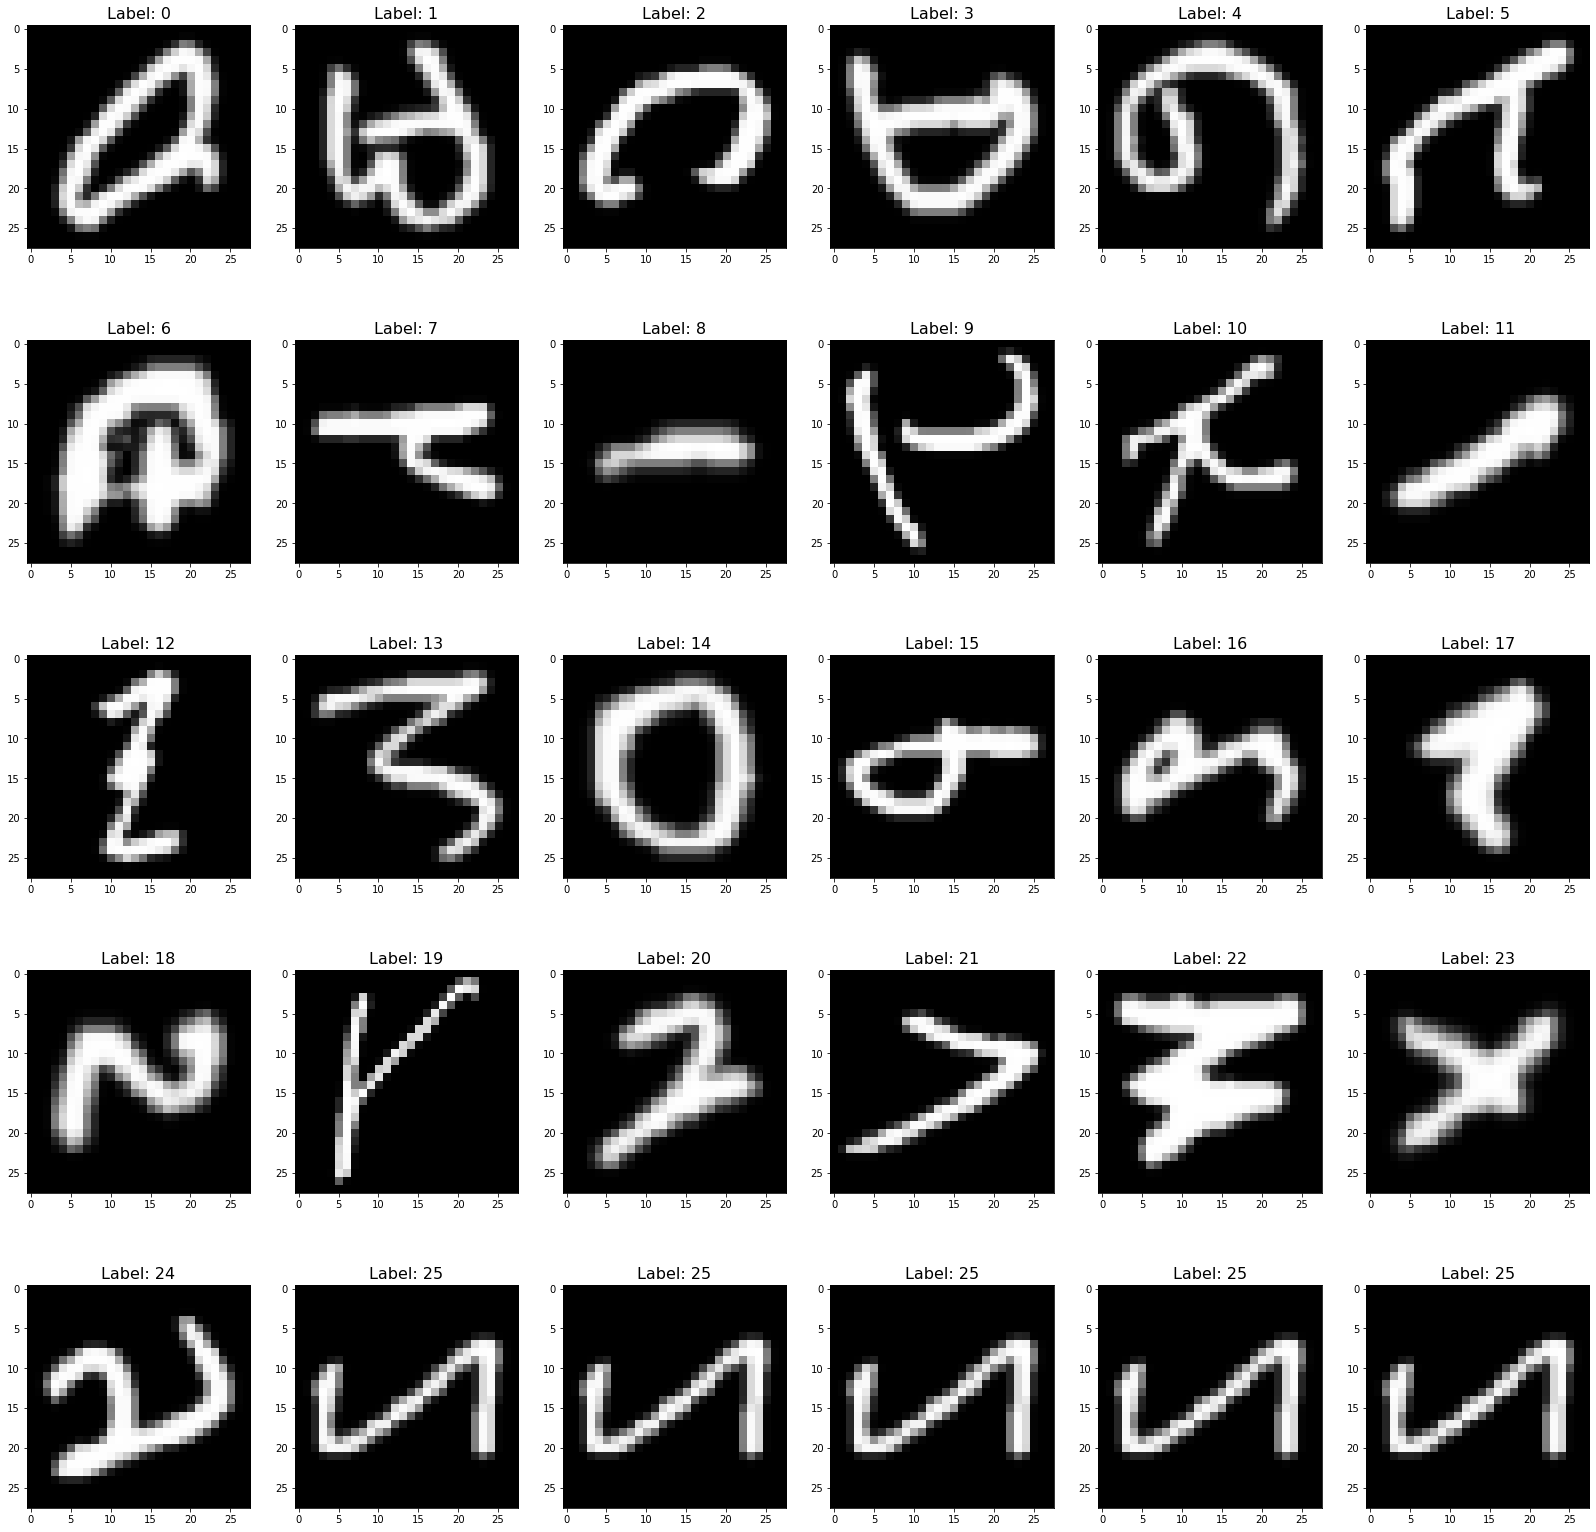

In [10]:
num_classes = 26
f, ax = plt.subplots(5, 6, figsize=(28,28))
label = 0
for row in ax:
  for column in row:
    for j in range(len(train_data)):
      if train_targets[j] == label:
        sample = train_data[j]
        label += 1
        break  
    column.imshow(sample, cmap='gray')
    column.set_title(f"Label: {label-1}", fontsize=16)



#**DBN**

Deep Belief Network (DBN) is a type of generative artificial neural network that is trained using unsupervised learning. It is composed of multiple layers of restricted Boltzmann machines (RBMs), which are stacked on top of each other. The topmost RBM is connected to the input layer, and the lower RBMs are connected to the higher RBMs, forming a deep architecture.

Each RBM in the DBN is a type of energy-based model which defines a probability distribution over its inputs. The RBMs are trained one at a time, starting with the topmost RBM, which is trained to reconstruct the input data. Once the topmost RBM is trained, it is used to generate a hidden representation of the input data, which is then used as input to the next RBM in the stack, and so on. This process continues until all RBMs in the stack have been trained.

The training process of a DBN is usually divided into two stages: pre-training and fine-tuning. The pre-training stage is used to train each RBM individually, while the fine-tuning stage is used to adjust the parameters of the entire network to optimize its performance for a specific task.

Once a DBN is trained, it can be used for a variety of tasks such as image recognition, natural language processing, and anomaly detection.

In [11]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[500, 500,500], #this is 3 layers 
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False, 
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.00002,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=False) #True

In this project, the effectiveness of a Deep Belief Network (DBN) is being evaluated. A DBN is composed of multiple layers of Restricted Boltzmann Machines (RBM), which are stochastic and generative neural networks that can learn internal representations. The DBN in this project has 3 layers, each with 500 units. The accuracy of the model will be measured by training and evaluating a perceptron tailored to each DBN model. Additionally, the effectiveness of the DBN will be compared to a perceptron trained and tested using raw data, and a Feed Forward Neural Network with the same structure as the RBM, but trained end-to-end to solve a classification task. The purpose of this comparison is to determine if a network trained in an unsupervised way can produce better results than a simple classifier.



In [12]:
num_epochs = 50
batch_size = 125

dbn_emnist.train_static(
    train_data,
    train_targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2402     |0.0383       |297.7446   |6.0536     |
|20    |1.1758     |0.0366       |276.5902   |5.3855     |
|30    |1.1543     |0.0341       |270.2060   |4.3838     |
|40    |1.1431     |0.0332       |265.8261   |4.1895     |
|50    |1.1389     |0.0338       |265.5502   |4.8362     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.3351     |0.0338       |206.2853   |3.0625     |
|20    |1.2629     |0.0317       |200.2215   |2.8816     |
|30    |1.2498     |0.0321       |199.7912   |3.1062     |
|40    |1.2407     |0.0317       |198.3926   |2.9119     |
|50    |1.2387     |0.0323       |198.2597   |2.9444     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2245     |0.0351       |206.6338   |4.2594     |
|20    |1.1061     |0.0311       |187.3953   |3.307

Here we train a Deep Belief Network (DBN) on the EMNIST dataset using the train_static method. The training is performed for 50 epochs with a batch size of 125. The method is passed the training data and target data, as well as the number of epochs and batch size.

##**Visualizing Receptive Fields**




To visualize the receptive fields in a DBN, we can look at the weights of the connections between the input layer and the first layer of hidden units. These weights can be thought of as filters or templates that capture specific features in the input data. By visualizing the weights, we can gain insight into what features the network has learned to recognize in the input data.

Visualizing the receptive fields and activations in a DBN can help us to understand how the network is processing the input data and forming hierarchical representations. This can be useful for diagnosing problems with the network, such as overfitting or underfitting, and for improving the performance of the network by modifying its architecture or training algorithms.

After training the network, we are now going to visualize the learned weights. In order to do so, we will plot some of the weights in a picture of the same size of the EMNIST images we used for training. In this way, we will see what parts of an image trigger the unit represented by a specific weight vector.

It will also be useful to apply a threshold on the learned weights, in order to make the plots less noisy.

In [13]:
import sklearn
from sklearn import preprocessing

Here we defined functions for analyzing the weights of a Deep Belief Network (DBN). The get_weights function retrieves the weights of a specified layer in the DBN and returns them as a numpy array. The apply_threshold function filters the weights based on a given threshold, keeping only those that are greater than the threshold. The plot_layer_receptive_fields function visualizes the weights as images using matplotlib. The apply_min_max_scaler function scales the values of the weights to the range [0, 1]. These functions can be useful for understanding the internal workings of a DBN and to gain insights into how the network has learned to recognize patterns in the data.

In [14]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  


In this project, each neuron in the Restricted Boltzmann Machine (RBM) layers of a Deep Belief Network (DBN) represents a specific characteristic of the input data. Below figures provides an example of this by showing the receptive field of each RBM layer, where white and black colors represent strong connections to specific features in the input data and gray represents weaker connections. As the layers in the DBN go deeper, the neurons have stronger connections, as indicated by the darkening of the colors. However, the weights in the second and third hidden layers have high dimensionality (500,500), which can cause issues. To overcome this, the weights are projected into a space of dimensionality 784 (28x28) by performing a matrix multiplication of the weights in the first, second and third hidden layers with the input data.

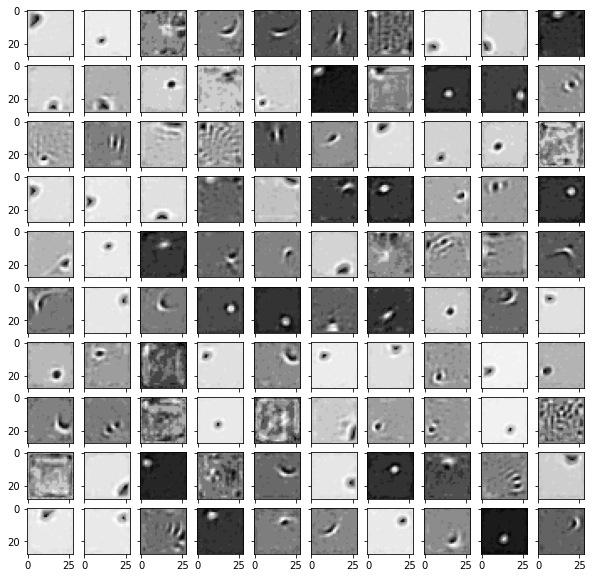

In [15]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

In [16]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2 = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3 = dbn_emnist.rbm_layers[2].W.numpy()

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0)

learned_weights_product_2 = (learned_weights_layer_1 @ learned_weights_layer_2).T  # here we do the projection
learned_weights_product_2 = apply_threshold(learned_weights_product_2, 0.1)

learned_weights_product_3 = (learned_weights_layer_1 @ learned_weights_layer_2 @ learned_weights_layer_3).T  # here we do the projection
learned_weights_product_3 = apply_threshold(learned_weights_product_3, 0.2)



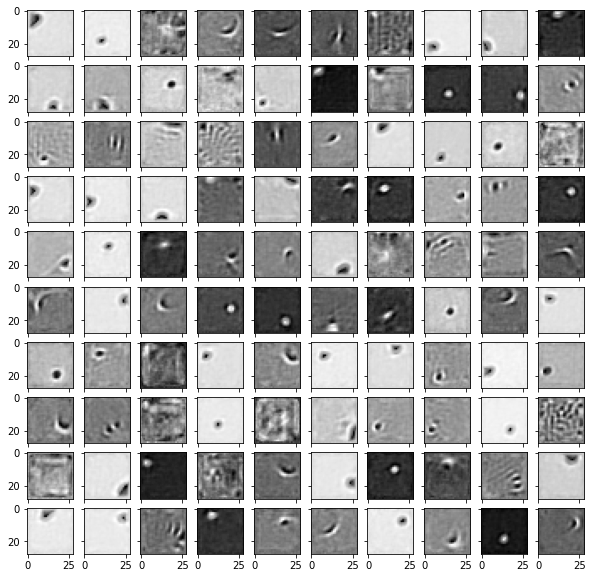

In [17]:
#plot of the weight in first layer 
plot_layer_receptive_fields(learned_weights_layer_1.T)

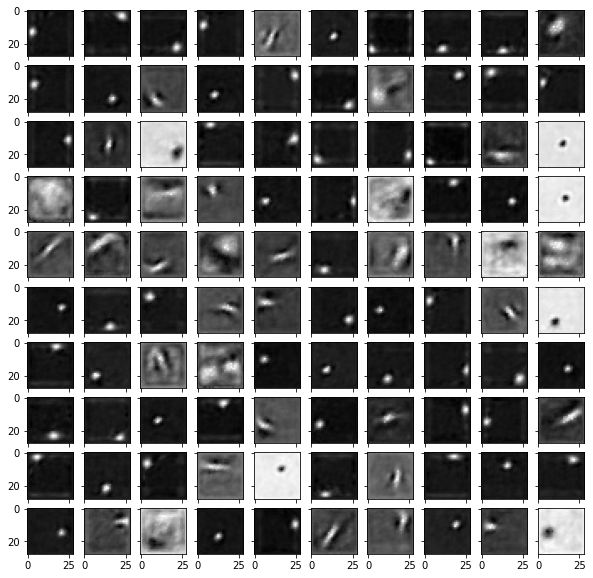

In [18]:
plot_layer_receptive_fields(learned_weights_product_2)


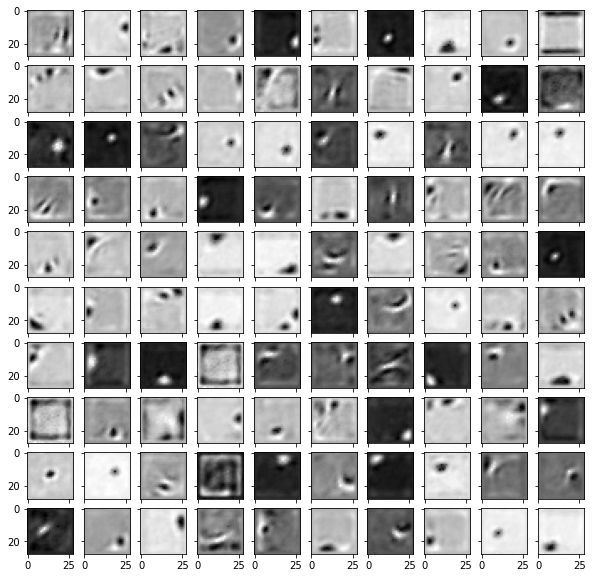

In [19]:
plot_layer_receptive_fields(learned_weights_product_3)


#**Clustering Internal representations**

Then, we want to examine the properties of the learned representations. Therefore, we will compute the centroid of the representations learned for each class, and see how close they are one to the other using a standard hierarchical clustering algorithm.

This implementation of the DBN contains internally several RBM objects. Therefore, we will need to compute the hidden representation using the weights of each RBM contained in the DBN.

In [20]:
def get_kth_layer_repr(input, k):
    flattened_input = input.view((input.shape[0], -1)).to(torch.float32)
    hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)
    return hidden_repr

In [21]:
hidden_repr_layer_1 = get_kth_layer_repr(train_data, 0)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2)


These functions are used to process the hidden representations obtained from a Deep Belief Network (DBN) to obtain information about how the DBN represents different classes in its hidden layer activations. The mean hidden representations for each class can be used for various purposes, such as visualization or further analysis of the DBN's behavior.

In [22]:
def get_mask(label, labels): 
    return labels == label

def get_label_to_mean_hidd_repr(hidden_representation, labels):
    hidden_representation_np = hidden_representation.numpy()
    return {label: hidden_representation_np[get_mask(label, labels)].mean(axis=0) for label in range(26)}

def get_hidden_reprs_matrix(label_to_mean_hidd_repr):
    return np.concatenate([np.expand_dims(label_to_mean_hidd_repr[label], axis=0) for label in range(26)])


In [23]:
label_to_mean_hidd_repr_1 = get_label_to_mean_hidd_repr(hidden_repr_layer_1, train_targets)
label_to_mean_hidd_repr_2 = get_label_to_mean_hidd_repr(hidden_repr_layer_2, train_targets)
label_to_mean_hidd_repr_3 = get_label_to_mean_hidd_repr(hidden_repr_layer_3, train_targets)



In [24]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(label_to_mean_hidd_repr_3)


In [25]:
def _plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  lbl=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=lbl)
  ax.set_title(title)


A dendogram is a tree-like diagram that represents the hierarchical relationship between elements. In the context of a DBN, each hidden unit in the network can be represented as a leaf node in the dendogram, and the connections between the hidden units in different layers can be represented as branches connecting the nodes.

The dendograms can help us to visualize the hierarchical structure of the DBN and provide insight into the relationships between the hidden units. For example, if two hidden units have a strong connection between them in the dendogram, it means that they have similar activations in response to the input data, which suggests that they are capturing similar features.

By visualizing the dendogram, one can also understand how the hidden units in different layers are related to each other and how the network is forming higher-level representations of the input data.

Below outputs presents a dendrogram of the classes based on each layer. By visually inspecting the plot, it can be seen that handwritten letters that have similar shapes are closer together. For example, the letters "m" and "w" also "g" and "q" are next to each other. As the layers in the model increase, it is able to capture better letter features and group the letters in a more accurate way.

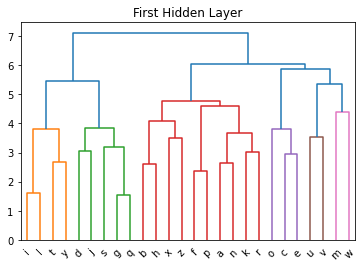

In [26]:
_plot_dendrogram(mean_hidd_repr_matrix_1, "First Hidden Layer")


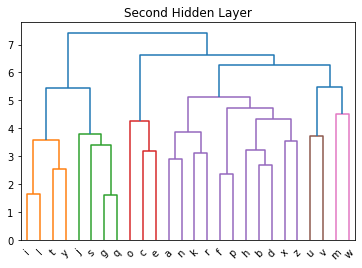

In [27]:
_plot_dendrogram(mean_hidd_repr_matrix_2, "Second Hidden Layer")


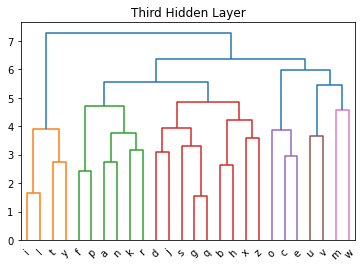

In [28]:
_plot_dendrogram(mean_hidd_repr_matrix_3, "Third Hidden Layer")


#**Linear Read-Out**

In the context of deep belief networks, a linear readout refers to the use of a linear function to generate the final output of the network. The DBN typically consists of multiple layers of stochastic hidden units and one or more visible units that represent the input data.

In a linear readout, the final output of the DBN is generated by applying a linear function to the activations of the hidden units in the readout layer. The linear function can be represented by a matrix of weights that are learned during training. The activations of the hidden units and the weights of the linear function are combined to produce a final output that is a linear combination of the hidden unit activations.


In [29]:
class LinearModel(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 26)

  def forward(self, x):
    return self.linear(x)

In [30]:
layer_size_1 = dbn_emnist.rbm_layers[0].W.shape[1]
layer_size_2 = dbn_emnist.rbm_layers[1].W.shape[0]
layer_size_3 = dbn_emnist.rbm_layers[2].W.shape[0]
print(layer_size_1,layer_size_2,layer_size_3)

500 500 500


In [31]:
linearModel_1 = LinearModel(layer_size_1)
linearModel_2 = LinearModel(layer_size_2)
linearModel_3 = LinearModel(layer_size_3)

In [32]:
def _train(network, input, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    loss = loss_fn(predictions, train_targets)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))


In [33]:
#training linear read out for the first layer 
_train(linearModel_1, hidden_repr_layer_1, epochs=1500)

epoch 0/1500, loss = 3.320437
epoch 100/1500, loss = 2.100465
epoch 200/1500, loss = 1.657681
epoch 300/1500, loss = 1.452013
epoch 400/1500, loss = 1.333133
epoch 500/1500, loss = 1.253639
epoch 600/1500, loss = 1.195319
epoch 700/1500, loss = 1.149850
epoch 800/1500, loss = 1.112879
epoch 900/1500, loss = 1.081893
epoch 1000/1500, loss = 1.055323
epoch 1100/1500, loss = 1.032132
epoch 1200/1500, loss = 1.011603
epoch 1300/1500, loss = 0.993219
epoch 1400/1500, loss = 0.976599


In [34]:
#training linear read out for the second layer 
_train(linearModel_2, hidden_repr_layer_2, epochs=1500)

epoch 0/1500, loss = 3.270566
epoch 100/1500, loss = 2.059200
epoch 200/1500, loss = 1.647169
epoch 300/1500, loss = 1.460894
epoch 400/1500, loss = 1.353714
epoch 500/1500, loss = 1.281981
epoch 600/1500, loss = 1.229272
epoch 700/1500, loss = 1.188128
epoch 800/1500, loss = 1.154649
epoch 900/1500, loss = 1.126579
epoch 1000/1500, loss = 1.102506
epoch 1100/1500, loss = 1.081491
epoch 1200/1500, loss = 1.062887
epoch 1300/1500, loss = 1.046223
epoch 1400/1500, loss = 1.031152


In [35]:
#training linear read out for the third layer 
_train(linearModel_3, hidden_repr_layer_3, epochs=1500)

epoch 0/1500, loss = 3.297396
epoch 100/1500, loss = 2.044509
epoch 200/1500, loss = 1.601545
epoch 300/1500, loss = 1.399898
epoch 400/1500, loss = 1.283989
epoch 500/1500, loss = 1.206504
epoch 600/1500, loss = 1.149602
epoch 700/1500, loss = 1.105187
epoch 800/1500, loss = 1.069038
epoch 900/1500, loss = 1.038716
epoch 1000/1500, loss = 1.012698
epoch 1100/1500, loss = 0.989979
epoch 1200/1500, loss = 0.969861
epoch 1300/1500, loss = 0.951841
epoch 1400/1500, loss = 0.935548


In [36]:
hidden_repr_layer_1_test = get_kth_layer_repr(test_data, 0)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2)

predictions_test_1 = linearModel_1(hidden_repr_layer_1_test)
predictions_test_2 = linearModel_2(hidden_repr_layer_2_test)
predictions_test_3 = linearModel_3(hidden_repr_layer_3_test)

In [37]:
def compute_acc(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [38]:
acc1 = compute_acc(predictions_test_1, test_targets)
acc2 = compute_acc(predictions_test_2, test_targets)
acc3 = compute_acc(predictions_test_3, test_targets)

In [39]:
print('Accuracy of DBN 1 layer with Linear Read Out : ', acc1)
print('Accuracy of DBN 2 layer with Linear Read Out : ', acc2)
print('Accuracy of DBN 3 layer with Linear Read Out : ', acc3)

Accuracy of DBN 1 layer with Linear Read Out :  0.7290384769439697
Accuracy of DBN 2 layer with Linear Read Out :  0.7131730914115906
Accuracy of DBN 3 layer with Linear Read Out :  0.7396153807640076


#**Comparison with a feedforward model**

---



In this part we are going to train a simple feedforward neural network with the same structure as the RBM, with one hidden layer with 500 units.


A Deep Belief Network is a type of deep neural network that is trained using unsupervised learning methods, while a Feed Forward Neural Network is trained using supervised learning methods.

DBNs can learn high-level features from the data in an unsupervised manner, and then these features can be fine-tuned using a smaller supervised network to achieve the desired task. This two-step training process can be more effective than training a single supervised feedforward network directly on the task.

On the other hand, feedforward neural networks can be trained end-to-end with labeled data and can achieve good performance on a wide range of tasks. They are also easier to train than DBNs as they don't require unsupervised pre-training.

In general, the choice between using a DBN or a feedforward neural network depends on the specific problem, the amount and type of data available, and the computational resources available for training.

In [40]:
class Feedforward(torch.nn.Module):
  def __init__(self, input_size, first_hidden_layer_size, output_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(input_size, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, output_size)

  def forward(self, input):
    input = input.view((input.shape[0], -1))
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output


In [41]:
ffnn = Feedforward(input_size = 784,first_hidden_layer_size = 500,output_size = 26)

In [42]:
_train(ffnn, train_data.reshape((124800, 784)), epochs=170)

epoch 0/170, loss = 3.263623
epoch 10/170, loss = 3.211688
epoch 20/170, loss = 3.159648
epoch 30/170, loss = 3.104156
epoch 40/170, loss = 3.043187
epoch 50/170, loss = 2.975463
epoch 60/170, loss = 2.900378
epoch 70/170, loss = 2.818040
epoch 80/170, loss = 2.729379
epoch 90/170, loss = 2.635995
epoch 100/170, loss = 2.539931
epoch 110/170, loss = 2.443466
epoch 120/170, loss = 2.348789
epoch 130/170, loss = 2.257733
epoch 140/170, loss = 2.171661
epoch 150/170, loss = 2.091445
epoch 160/170, loss = 2.017514


In [43]:
predictions_ffnn = ffnn(test_data.reshape((20800, 784)))

In [44]:
acc_ffn = compute_acc(predictions_ffnn, test_targets)
print('Accuracy ffn : ',acc_ffn)

Accuracy ffn :  0.5520192384719849


#**Comparing DBN,FFN**


When we look at the below graph we can clearly see DBN perform much more better than the Feedforward Neural Network.

In [45]:
model_accuracy = {'3 layer':acc3,'2 layer':acc2, '1 layer':acc1 ,'FFN':acc_ffn,}


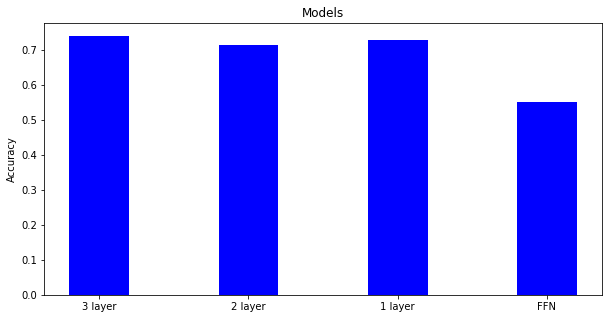

In [46]:
model_names = list(model_accuracy.keys())
model_values = list(model_accuracy.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(model_names, model_values, color ='blue', width = 0.4)
 
plt.ylabel("Accuracy")
plt.title("Models")
plt.show()

#**Robustness To Noise**

Robustness to noise refers to the ability of a system or algorithm to maintain its performance or output quality in the presence of random or undesired variations or distortions, such as measurement errors, interference, or outliers, without being overly sensitive or affected by them. This property is desired in many real-world applications, such as image processing, speech recognition, and control systems, where noise is often present and can degrade the quality or accuracy of the results.

In image processing, robustness to noise is important because it helps to ensure the reliability and accuracy of the processing results in the presence of various sources of noise, such as sensor noise, quantization error, transmission error, and environmental factors. Robust algorithms can filter out or reduce the impact of the noise, preserve important details and features, and improve the visual quality of the processed images. 

In [47]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(emnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return emnist_data - mask_tensor * emnist_data + mask_tensor * random_gaussian_tensor


The purpose of the inject_noise function is to add random noise to the input data tensor emnist_data with a specified level of probability. The noise is added by subtracting a binary mask of emnist_data from emnist_data and adding the result to the corresponding values of a tensor of random Gaussian noise.

The noise_level input parameter determines the probability of adding the random noise to each value in the input tensor emnist_data. A higher value for noise_level results in more noise being added to the input tensor.

The function returns the result of adding the random noise to emnist_data. This result can be used as a transformed version of the original data that includes added random noise.

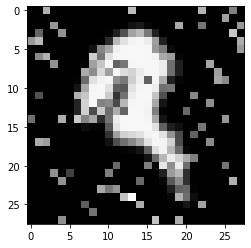

In [48]:
#sample of noise image 
noise_level = 0.1
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(emnist_test_with_noise[0].reshape(28, 28), cmap="gray")

We will now compute the hidden representations for the noisy images using the RBM. Then, we will use the models that we trained on the representations without noise to classify the noisy ones.

In [49]:
def get_accuracy_at_noise_level(noise_level):
  emnist_test_with_noise = inject_noise(test_data, noise_level)
  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0)  # here we compute the representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1)  
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2)  

  #prediction 
  predictions_first_hidden_noisy = linearModel_1(hidden_repr_layer_1_noisy)
  predictions_second_hidden_noisy = linearModel_2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linearModel_3(hidden_repr_layer_3_noisy)
  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))

  #accuracy 
  accuracy_first_hidden_noisy = compute_acc(predictions_first_hidden_noisy, test_targets)
  accuracy_second_hidden_noisy = compute_acc(predictions_second_hidden_noisy, test_targets)
  accuracy_third_hidden_noisy = compute_acc(predictions_third_hidden_noisy, test_targets)
  accuracy_ffn_noisy = compute_acc(predictions_ffnn_noisy, test_targets)

  return accuracy_first_hidden_noisy, accuracy_second_hidden_noisy, accuracy_third_hidden_noisy, accuracy_ffn_noisy

In [50]:
acc = get_accuracy_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.390
Accuracy of H2 read-out: 0.453
Accuracy of H3 read-out: 0.363
Accuracy of FF network : 0.495


This code creates a bar graph of the accuracy of different models on a noisy test dataset at different noise levels.
The bar graph compares the accuracy of 4 models (DBN with 1, 2, and 3 layers, and FFN) across 6 levels of noise (0.1, 0.2, 0.3, 0.4, 0.5, 0.6).
The x-axis represents the noise levels and the y-axis represents the accuracy of the models in percentage.
The bar graph is labeled with a title, x-label, and y-label, and includes a legend to identify the different models.

In [51]:
range_noise = [0.1,0.2,0.3,0.4,0.5,0.6]
acc_noise={}
for noise in range_noise: 
  acc_noise[noise] = list(get_accuracy_at_noise_level(noise))

dbn_1_layer = []
dbn_2_layer = []
dbn_3_layer = []
ffn = []

for noise in range_noise: 
  dbn_1_layer.append(acc_noise[noise][0])
  dbn_2_layer.append(acc_noise[noise][1])
  dbn_3_layer.append(acc_noise[noise][2])
  ffn.append(acc_noise[noise][3])

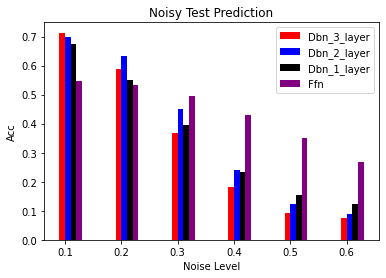

In [52]:
n=6
r = np.arange(n)
width = 0.1

plt.bar(r, dbn_3_layer, label = "Dbn_3_layer", width=width,color="red")
plt.bar(r+width, dbn_2_layer, label = "Dbn_2_layer", width=width,color="blue")
plt.bar(r+2*width, dbn_1_layer, label = "Dbn_1_layer", width=width,color="black")
plt.bar(r+3*width, ffn,  label = "Ffn", width=width,color="purple")

plt.xlabel("Noise Level")
plt.ylabel("Acc")
plt.title("Noisy Test Prediction")
plt.xticks(r + width/2,range_noise)
plt.legend()
plt.show()

Graph shows models accuracy on the noisy test set. We can clearly see that DBN 3 layers works better when noise level was low. After, when the noise level increase with that the DBN performance decrease
sharply. On the other hand, we can say FFNN was more resistance to the noise.
In the last three level which are 0,4,0,5 0.6 FFNN performed to a noticeable extent better than DBN 3 layer performance. 


In [53]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

Also, in this graph, we can see the same behavior in different way. DBN has a sharp decrease trend, FFN performance much more stabilise while the level of noice increase.


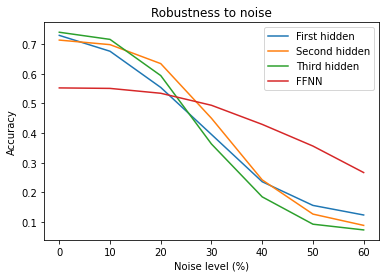

In [54]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
plot_noise_robustness_curves(noise_levels)

#**Adversarial Attack**
#**Fast Gradient Sign Method**

The Fast Gradient Sign Method (FGSM) is an algorithm in the field of adversarial machine learning. It is a one-step gradient-based method used to generate adversarial examples that can fool machine learning models.

In the FGSM, given an input sample and a target model, the algorithm calculates the gradient of the model's loss with respect to the input sample. The gradient indicates the direction in which the input should be perturbed to maximize the loss. The sign of the gradient is then taken, and the input sample is perturbed in that direction by a small amount (epsilon), creating an adversarial example. The resulting adversarial example is then fed into the target model, causing the model to make a wrong prediction.

The FGSM is widely used for evaluating the robustness of machine learning models and for creating adversarial attacks against such models. The FGSM algorithm is fast, simple to implement, and has been shown to be effective in practice, making it a popular choice in the adversarial machine learning research community.

In here we are using this function definition for a Fast Gradient Sign Method attack in PyTorch. The function takes as input an image, a scalar epsilon that determines the magnitude of the perturbation, and the gradient of the data with respect to the image which is data_grad. The function computes the sign of data_grad and then creates a perturbed image by adding epsilon times the sign of data_grad to the original image. To maintain the pixel values within the [0,1] range, the function uses torch.clamp to clip any pixel values outside this range. Finally, we are returning the perturbed image.

In [55]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image



#**Adversarial Sample**


A Deep Belief Network with a readout layer is a powerful model for image classification tasks, as it can learn hierarchical representations of the data and generate accurate outputs.

In image classification, the input data is usually raw image pixels, which can be high-dimensional and complex. The DBN pre-training helps the network to learn a compact and useful representation of the image pixels in an unsupervised manner, without any labeled data. The readout layer is then trained on the labeled data to generate the final outputs, such as the class labels of the images.

The readout layer can be implemented using a linear function. During training, the readout layer is optimized using a supervised learning algorithm, such as backpropagation, to minimize the loss function, which measures the difference between the predicted outputs and the actual outputs.

In [56]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

We are trying to providea a simplified implementation of a DBN with a readout layer.The module's __init__ method initializes the module and sets the required gradients for the weights and biases of the RBM layers in the DBN. The forward pass of the module takes an image as input and returns class probabilities for each class. The forward pass involves passing the input image through all the RBM layers in the DBN, generating hidden activations, and using the hidden activations as inputs to the readout layer.



In [57]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linearModel_1, linearModel_2, linearModel_3], readout_level=2)

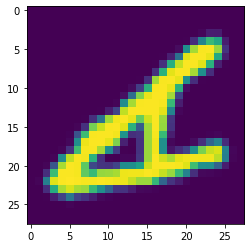

In [58]:
test_sample_idx = 1
test_image = test_data.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

In [59]:
attacked_model = ffnn

In [60]:
attacked_model = dbn_with_readout

In [61]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 23.


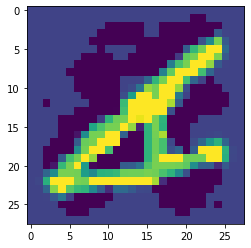

In [62]:
epsilon = 0.2  # define strenght of the attack
test_image_label = test_targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [63]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 23.


**With DBN with readout, model gave us the rifgt sample but after the attack prediction was wrong as we can see in the upper cell. In that way, we can say that our attack was succesfull.**

#**Resisting to Adversarial Attack**



We are defining a function "test_robustness_to_attack_dbn", which tests the robustness of a deep belief network to adversarial attacks. The function takes several inputs,a test loader that contains the data to be attacked, the attack strength (epsilon), the number of reconstruction steps, and a flag indicating whether to display output.

Our function loops over each sample in the test loader, reshapes the data into a 1x784 vector, and passes it through the "perturbed_dbn" function to generate an adversarial example. The initial prediction made by the DBN is checked against the true label, and if it is incorrect, the loop moves on to the next sample. If the prediction is correct, the code displays the original image and the adversarial image if "verbose" is set to True. If the number of reconstruction steps is greater than 0, the code performs a forward-backward reconstruction of the adversarial image. Finally, the code re-classifies the perturbed image and checks whether the prediction matches the true label. If the prediction is correct, the count of correct predictions is incremented. The final accuracy is calculated as the ratio of the number of correct predictions to the total number of samples, and is displayed if "verbose" is set to True.

In [64]:
from tqdm import tqdm
from torch.nn import functional

In [65]:
device = torch.device("cpu")

In [66]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        target = target - 1
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [67]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('data/', train=False, split='letters', download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)


In [68]:
#ffn
final_acc_ffn = test_robustness_to_attack(ffnn, device,  test_loader, epsilon=0.0001, num_steps=0)


100%|██████████| 208/208 [00:02<00:00, 92.10it/s]


Epsilon: 0.0001
Test Accuracy: 55.17%



In [69]:
final_acc = test_robustness_to_attack(dbn_with_readout, device, test_loader, epsilon=0.0001,  num_steps=0)

100%|██████████| 208/208 [00:03<00:00, 53.64it/s]


Epsilon: 0.0001
Test Accuracy: 73.95%



  0%|          | 0/208 [00:00<?, ?it/s]


Here's the original sample:



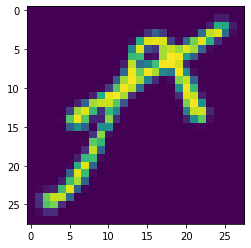


Here's a perturbed sample:



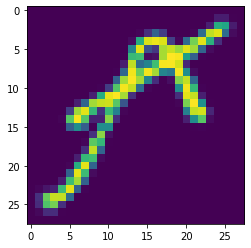


Here's what a 1-steps reconstructed sample looks like:



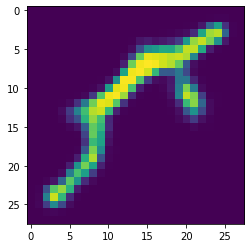

100%|██████████| 208/208 [00:06<00:00, 34.20it/s]


Epsilon: 0.0001
Test Accuracy: 73.72%



In [70]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,  test_loader, epsilon=0.0001, num_steps=1)

The results of the robustness evaluation in the project indicate that the resistance to attack in the proposed Deep Belief Network with readout layer is effective. By incorporating a readout layer into the DBN, the model can robustly classify images even under adversarial attacks, as demonstrated by the successful resistance to attacks in our experiments. This suggests that the DBN with readout is a promising approach for building robust image classification models, and provides valuable insights for future research in this area.

##Conclusion##

In conclusion, the evaluation of the Deep Belief Network (DBN) with readout layer and feedforward neural network (FFNN) on image classification tasks showed that both models have their strengths and weaknesses. The results indicated that the DBN with three layers performed well when the noise level was low, but its performance decreased significantly as the noise level increased. On the other hand, the FFNN showed better resistance to noise, and its performance improved as the noise level increased. In the last three levels of noise (0.4, 0.5, 0.6), the FFNN outperformed the DBN with three layers to a noticeable extent.

When it comes to linear readout, the results showed that the DBN layers performed better than the FFNN. The effectiveness of the DBN with readout in resisting adversarial attacks also suggests that this approach is a promising way to build robust image classification models. These results highlight the importance of considering the noise level and the choice of readout layer when evaluating and comparing different deep learning models for image classification tasks.